# Introduction

In this project, I will be predicting the churn for customers at ABC Multinational Bank. I will start by performing exploratory data analysis to attempt to find any patterns and identify what features might be the biggest drivers of churn. Next, I will perform data preprocessing to prepare the data for modeling. I will then test out a few different models and select the best one to use for predicting churn. Finally, I will generate a list of customers who are at risk of churning. These customers can then be targeted with marketing campaigns to try to retain them.

*Also see the business report for this project: https://medium.com/@dpapcodes/investigating-why-customers-leave-a-bank-47b41278e36c*

**Dataset Information**

The dataset was obtained from Kaggle (https://www.kaggle.com/datasets/gauravtopre/bank-customer-churn-dataset) and includes 12 columns and 10,000 rows, where each row represents a customer. The dataset includes the following columns: customer_id (numerical, a unique ID given to identify each customer), credit_score (numerical, a score that identifies the creditworthiness of a customer), country (categorical, represents the country where the customer is located - it can be one of three countries: Spain, Germany, or France), gender (categorical, represents the customer's gender), age (numerical, represents the customer's age), tenure (numerical, representing how long the customer has been at the bank given in years), balance (numerical, representing the amount of USD the customer has at the bank), products_number (numerical, representing the number of products the customer has at the bank), credit_card (is a binary categorical variable, representing if the customer has a credit card at the bank or not - 0 = no, 1 = yes), active_member (is a binary categorical variable, representing if the customer is an active member at the bank), estimated_salary (numerical, representing the estimated total income of the customer in USD), and churn (used as the target variable, is a binary categorical variable and represents if the customer has left the bank during some period of time - 0 = they have not, 1 = they have).


# Load Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score


In [2]:
df = pd.read_csv('customers.csv')

In [3]:
df.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# EDA
The main objectives in this section is to better understand the customers and their behavior and create new features that might be useful for modeling.

**Customer Churn in the Banking Industry**

Per Customer Gauge, the average churn rate among all industries is 21%, but in the financial industry, the churn rate is 25% and is the highest among all industries (Howarth, 2022). This means that 1 in 4 customers will leave their bank. This is a huge problem for banks because it costs 5 times more to acquire a new customer than to retain an existing one. It was also found that 56% of customers who left say the bank could have changed their mind (Gardner, 2019). Therefore, it is important for banks to identify customers who are at risk of churning and target them with marketing campaigns to try to retain them.

In [4]:
# Function to do some basic EDA
def basic_eda(df):
    '''Function that prints basic EDA information.
    
    # Argument
        df: dataframe with the features you want to examine.
            Should be the original dataframe, before separating target.
    # Returns
        Prints the shape, number of duplicate rows, number of nulls,
        data types, unique value counts for each feature, basic statistics
        for numerical columns, and distribution of categorical columns.
    '''
    print('***** BASIC EDA *****')
    print(f'\nDATA SHAPE: {df.shape}')
    print(f'\nNUMBER OF DUPLICATES: {df.duplicated().sum()}')
    print(f'\nMISSING VALUE COUNTS:\n{df.isnull().sum()}')
    print(f'\nDATA TYPES:\n{df.dtypes}')
    print('\nCOUNT OF UNIQUE VALUES IN EACH COLUMN: ')
    for col in df.columns:
        print(col, ':', df[col].nunique())
    print(f'\nDISTRIBUTION OF TARGET VARIABLE: \n{df.churn.value_counts()}')
    print('\nDISTRIBUTION OF CATEGORICAL COLUMNS: ')
    for col in df.select_dtypes(include=['object', 'category']):
        print(df[col].value_counts(), '\n')
        
basic_eda(df)

***** BASIC EDA *****

DATA SHAPE: (10000, 12)

NUMBER OF DUPLICATES: 0

MISSING VALUE COUNTS:
customer_id         0
credit_score        0
country             0
gender              0
age                 0
tenure              0
balance             0
products_number     0
credit_card         0
active_member       0
estimated_salary    0
churn               0
dtype: int64

DATA TYPES:
customer_id           int64
credit_score          int64
country              object
gender               object
age                   int64
tenure                int64
balance             float64
products_number       int64
credit_card           int64
active_member         int64
estimated_salary    float64
churn                 int64
dtype: object

COUNT OF UNIQUE VALUES IN EACH COLUMN: 
customer_id : 10000
credit_score : 460
country : 3
gender : 2
age : 70
tenure : 11
balance : 6382
products_number : 4
credit_card : 2
active_member : 2
estimated_salary : 9999
churn : 2

DISTRIBUTION OF TARGET VARIABLE: 
0  

In [5]:
# See statistics for numerical columns
df.describe()

,customer_id,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


We have 10,000 rows and 12 columns in the original dataset and have no nulls or duplicates. From the summary, we see about 70% of the customers have a credit card, about 50% of the customers are an active member, and most customers did not churn, compared to those who did churn (roughly 20% of the customers churned). We also notice that some features, such as `credit_score`, `age`, `balance`, and `estimated_salary` have different ranges and scales and only 2 variables are categorical, but taking a closer look at our data, we see that `credit_card` and `active_member` should also be categorical variables (binary categorical). Therefore, we will need perform some standardization and convert some features to categorical variables so that the model does not interpret them as numerical.

## Demographic Analysis
- Analyzing `age`, `gender`, and `country` to see if there are any patterns in the data.

In [6]:
# Function to make bar plots for EDA
def make_bar_plot(calculated_variable, x_label, y_label, title, ylim=0):
    '''Function to make bar plots for EDA.
    
    # Arguments
        calculated_variable: string, variable you are plotting
        x_label: string, x-axis label
        y_label: string, y-axis label
        title: string, title of graph
        ylim: int, starting number on y-axis
        
    # Returns
        A bar chart
    '''
    fig, ax = plt.subplots()
    sns.barplot(x=calculated_variable.index, y=calculated_variable.values)
    plt.bar_label(ax.containers[0], fmt='%.2f')
    ax.set_ylim(ylim,)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    plt.show()

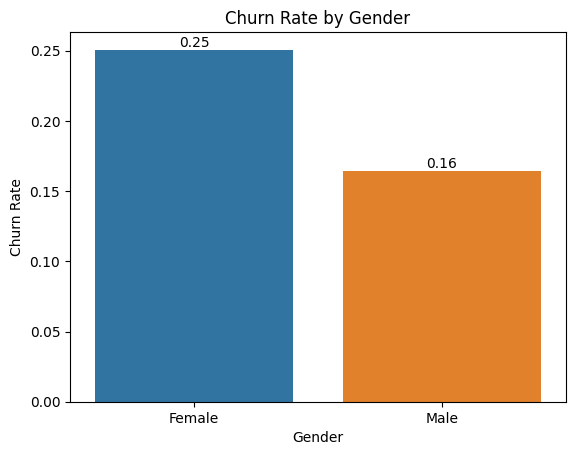

In [7]:
# Plot of the churn rates for each gender
churn_rate_gender = df.groupby('gender')['churn'].mean()
make_bar_plot(churn_rate_gender, 
              x_label='Gender', 
              y_label='Churn Rate', 
              title='Churn Rate by Gender')

In [8]:
# Binning the age feature
agebins = [18, 30, 40, 50, 60, 70, 80, 100]
agelabels = ['18-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81+']
df['age_bins'] = pd.cut(df['age'], bins=agebins, labels=agelabels)

In [9]:
# Number of customers in each age group
df['age_bins'].value_counts()

31-40    4451
41-50    2320
18-30    1946
51-60     797
61-70     331
71-80     121
81+        12
Name: age_bins, dtype: int64

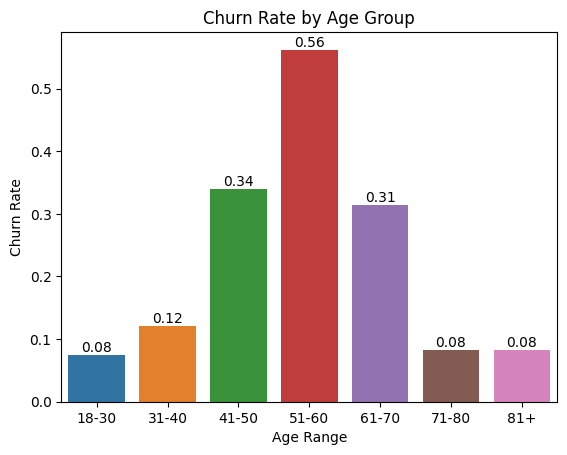

In [10]:
# Plot of the churn rates for each age group
churn_rate_age = df.groupby('age_bins')['churn'].mean()
make_bar_plot(churn_rate_age, 
              x_label='Age Range', 
              y_label='Churn Rate', 
              title='Churn Rate by Age Group')

In the demographic analysis, we find that females churn more than males do, which might indicate some level of gender discrimination. Business Insider found that many financial service providers has failed to serve women and they could generate $700 billion in additional annual revenue if they were to provide financial services to women at the same rate they are provided to men (Iskenderian, 2022). Catering more services towards women would be helpful in retaining this demographic. 

We also find that older customers are more likely to churn than younger ones. This could be because most of the amenities for this age group tends to be the same across the industry, whereas older customers may start thinking about retirement, pensions, inheritance, taxes, etc. which means they will be interested in finding the bank that offers the best deal. It could also be because older customers value customer service and real-life interactions more than younger customers do. As more banks head towards digitalization, older customers may leave the bank if it means finding banks that better offer those traditional services.

*TLDR: We find that women churn more than men and older people churn more than younger people, with the peak churn rates occurring in the 50-60 age group.*

## Creditworthiness Analysis
- Analyzing `credit_score` to see if there are any patterns in the data.

In [11]:
# Binning the credit score feature
# Poor and Fair (350-669), Good (670-739), Excellent (740-850)
creditscorebins = [0, 669, 739, 850]
creditscorelabels = ['Poor', 'Good', 'Excellent']
df['cs_bins'] = pd.cut(df['credit_score'], 
                       bins=creditscorebins, labels=creditscorelabels)

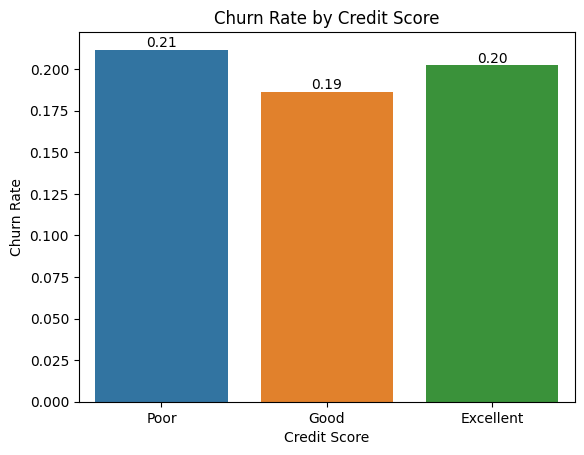

In [12]:
# Plot the churn rate for each credit score group
churn_rate_creditscore = df.groupby('cs_bins')['churn'].mean()
make_bar_plot(churn_rate_creditscore, 
              x_label='Credit Score',
              y_label='Churn Rate',
              title='Churn Rate by Credit Score')

Which age group has the lowest credit score? Does this explain the churn rate for that group?

In [13]:
# Average credit score for each age group
df['creditscore_per_age'] = df.groupby('age_bins')['credit_score'].transform('mean')

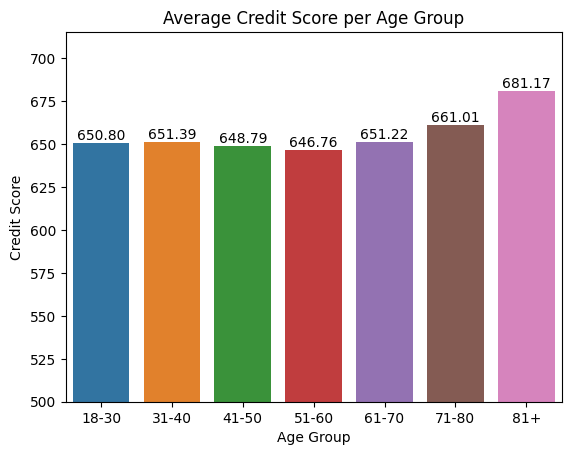

In [14]:
# Plot the average credit score for each age group
avg_creditscore_per_age = df.groupby('age_bins')['credit_score'].mean()
make_bar_plot(avg_creditscore_per_age,
              x_label='Age Group',
              y_label='Credit Score',
              title='Average Credit Score per Age Group',
              ylim=500)

People with lower credit scores are usually charged with higher interest rates, higher insurance premiums, and higher chances of being deinied loans, which should mean they are more likely to churn. Therefore, we clustered them into three groups: "Poor", "Good", and "Excellent" based on the FICO rating system. Logically, those with a "Poor" rating had the highest churn rate. 

We then calculated the average credit score for each age group. This offers a possible explanation for why the 50-60 age group had the highest churn rate, the higher probability of churn is not solely because of their age, but because of their credit score given their age group.

*TLDR: Customers with low credit scores churn more and the 50-60 age group doesn't churn more only because of their age, but because they are the age group with the lowest credit score.*

## Customer Engagement Analysis
- Analyzing `tenure`, `products_number`, `credit_card`, and `active_member` to see if there are any patterns in the data.
- Are more engaged customers (longer tenure, more products, active membership) less likely to churn? Or perhaps long-tenure customers are more likely to churn due to complacency in the customer service they receive? 

### *Active vs. Inactive Members*

In [15]:
# Active member value counts
df['active_member'].value_counts()

1    5151
0    4849
Name: active_member, dtype: int64

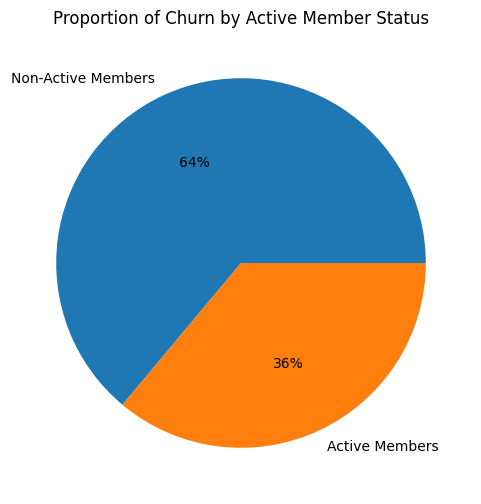

In [16]:
# Pie chart of proportion of churn by active member status
# Get counts of churned customers in each 'active_member' category
churn_counts_by_active_member = df[df['churn'] == 1]['active_member'].value_counts()

# Convert these counts into proportions
total_churn = churn_counts_by_active_member.sum()
churn_proportions = (churn_counts_by_active_member / total_churn) * 100

# Create the pie chart
plt.figure(figsize=(6,6))
plt.pie(churn_proportions, 
        labels = ['Non-Active Members', 'Active Members'], 
        autopct='%1.f%%')
plt.title('Proportion of Churn by Active Member Status')
plt.show()

Do active or non-active members have lower credit? Does this explain the higher churn rate for that group?

In [17]:
# Average credit scores for active member status
df.groupby('active_member')['credit_score'].mean()

active_member
0    647.973603
1    652.934188
Name: credit_score, dtype: float64

### *Number of Products*

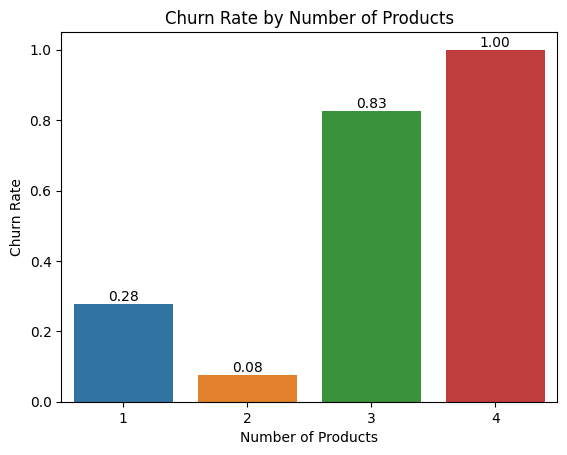

In [18]:
# Plot the churn rate by number of products they have at the bank
churn_rate_by_num_prods = df.groupby('products_number')['churn'].mean()
make_bar_plot(churn_rate_by_num_prods,
              x_label='Number of Products',
              y_label='Churn Rate',
              title='Churn Rate by Number of Products')

Why are customers with 2 products ideal customers?

In [19]:
# Make a table to see various features of customers with 2 products
features_to_check = ['active_member', 'credit_score', 'age', 'balance']
df.groupby('products_number')[features_to_check].mean().style.background_gradient(cmap='BuGn')

,active_member,credit_score,age,balance
products_number,,,,
1,0.504131,649.120968,39.673092,98551.870614
2,0.532898,652.188671,37.753595,51879.145813
3,0.424812,648.105263,43.195489,75458.328195
4,0.483333,653.583333,45.683333,93733.135000


Customers with 2 products are usually active members, have a high credit score, are younger, and have a lower balance than customers with 1, 2, or 4 products.

### *Engagement Score*
- Scoring system based on `tenure`, `products_number`, and `active_member` to calculate how engaged a customer is.

In [20]:
# Create an engagement score feature to calculate how enagaged a customer is
# Standardize tenure and products number so theyre the same scale as active members
df['tenure_normalized'] = (df['tenure'] - 
                            df['tenure'].min()) / (df['tenure'].max() - 
                            df['tenure'].min())
df['prod_num_normalized'] = (df['products_number'] - 
                             df['products_number'].min() / df['products_number'].max() - 
                             df['products_number'].min())

# Calculate engagement score and add to dataframe
df['engagement_score'] = (df['tenure_normalized'] + 
                          df['prod_num_normalized'] + 
                          df['active_member'])

# Add weights if one feature is more important than others: 
# df['engagement_score'] = (df['tenure_normalized'] + 
#                           df['prod_num_normalized'] + 
#                           2*df['active_member'])

In [21]:
# Drop temporary columns
df = df.drop(columns=['tenure_normalized', 'prod_num_normalized'])

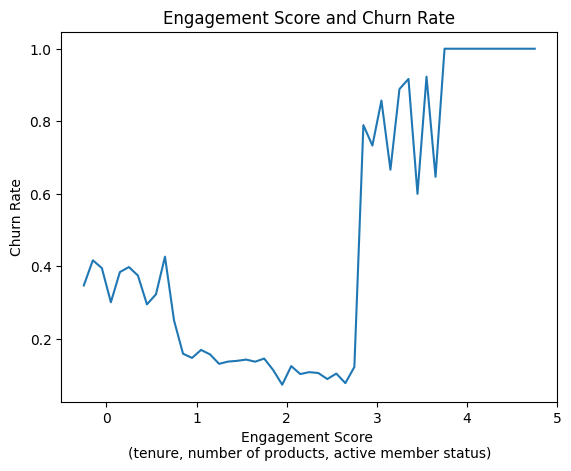

In [22]:
# Plot churn rate for engagement scores
engagement_churn = df.groupby('engagement_score')['churn'].mean()
fig, ax = plt.subplots()
sns.lineplot(x=engagement_churn.index, y=engagement_churn.values)
ax.set_title('Engagement Score and Churn Rate')
ax.set_xlabel('Engagement Score \n(tenure, number of products, active member status)')
ax.set_ylabel('Churn Rate')
plt.show()

Analyzing customer engagement, we first found that non-active customers are almost 30% more likely to leave the bank than active ones. We then found non-active customers also seemed to be less financially responsible as their credit scores are lower.

We then find that customers with 2 products are ideal customers, as they have the lowest churn rate by far. Although customers with only 1 product were relatively riskier than those with 2, they were much less risky than those with 3 or 4 products and should be considered safe. These customers were younger, typically active members (moreso than customers with 1, 3, or 4 products), had a high average credit score, and were majority male. This might be the demographic you will not need to worry about or target for an ad campaign because they are less likely to switch banks. However, customers with more than 2 products almost always meant they bit off more than they could chew and were likely to leave the bank.

Finally, we calculated an engagement score based on tenure, active member status, and number of products. We found that the higher the engagement score, the higher the churn rate. This could indicate an issue with the customer service. The bank should look into their customer service and see if there is a problem with the way they are treating their customers to attempt to resolve this. 

*TLDR: Active members are less likely to churn than non-active members. Customers with 2 products are ideal customers. The higher the engagement score, the higher the churn rate, which could indicate an issue with customer service.*

## Financial Status Analysis
- Analyzing `balance` and `estimated_salary` to see if there are any patterns in the data.

### *Balance*

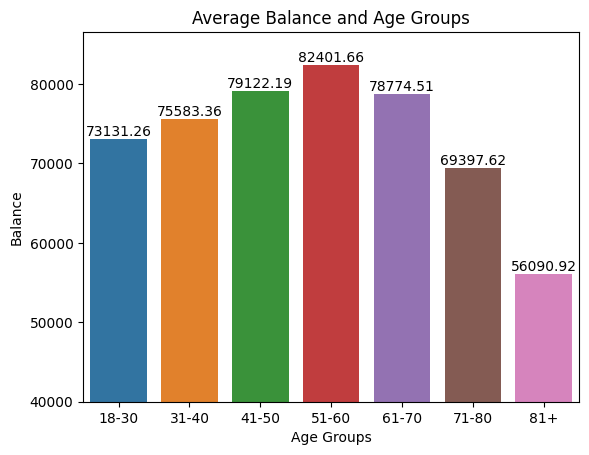

In [55]:
# Plot age groups and balance
age_balance = df.groupby('age_bins')['balance'].mean()
make_bar_plot(age_balance,
              x_label='Age Groups',
              y_label='Balance',
              title='Average Balance and Age Groups',
              ylim=40000)

### *Balance to Salary Ratio*

In [23]:
# Calculate balance to salary ratio for each customer
df['balance_salary_ratio'] = df['balance'] / df['estimated_salary']

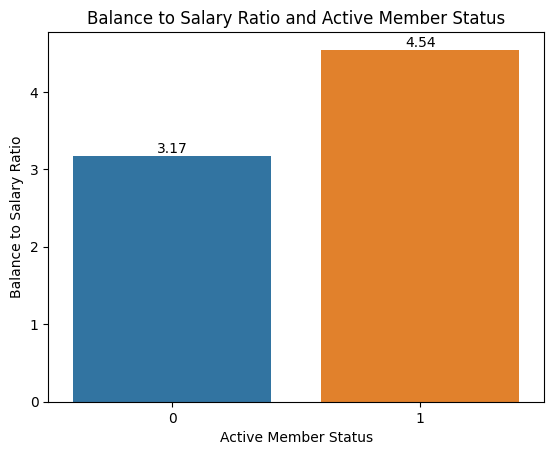

In [24]:
# Plot active member status and balance to salary ratio
active_member_bsratio = df.groupby('active_member')['balance_salary_ratio'].mean()
make_bar_plot(active_member_bsratio,
              x_label='Active Member Status',
              y_label='Balance to Salary Ratio',
              title='Balance to Salary Ratio and Active Member Status')

When analyzing financial status, we first looked at the average balance for each of the age groups to investigate if this can be another factor into why older customers tend to churn more. We found that the age groups that churned the most did have the highest average balance. This reinforces my belief that these customers might be shopping around to other banks looking for the best deal for their retirement, pensions, etc. Next, we calculated a balance to salary ratio. A higher balance to salary ratio might indicate that group is more financially responsible, as they put more of their salary in a bank account. Active members had a ratio of 4.54 compared to non-active members at 3.17, indicating that non-active members' money might have been flowing to more than one bank as a result of the inability to get certain products at one bank due to their low credit scores, or they simply had poor money management skills. 

*TLDR: The age groups with the highest churn rates have the highest balances and active members have a higher balance to salary ratio than non-active members and have a higher credit score.*

# Data Preprocessing

Since we identified that some numerical columns have different scales, we will need to scale them to make sure they are all on the same scale. We will also need to one hot encode the categorical features. To do this, we will use StandardScaler and OneHotEncoder from sklearn.preprocessing. We will also need to drop some columns that we will not be using in our model. Then we will use ColumnTransformer to apply the transformations to the correct columns when we build our pipelines.

In [26]:
df

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,age_bins,cs_bins,creditscore_per_age,engagement_score,balance_salary_ratio
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1,41-50,Poor,648.794397,0.95,0.000000
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,41-50,Poor,648.794397,0.85,0.744677
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,41-50,Poor,648.794397,2.55,1.401375
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0,31-40,Good,651.391148,0.85,0.000000
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,41-50,Excellent,648.794397,0.95,1.587055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,15606229,771,France,Male,39,5,0.00,2,1,0,96270.64,0,31-40,Excellent,651.391148,1.25,0.000000
9996,15569892,516,France,Male,35,10,57369.61,1,1,1,101699.77,0,31-40,Poor,651.391148,1.75,0.564108
9997,15584532,709,France,Female,36,7,0.00,1,0,1,42085.58,1,31-40,Good,651.391148,1.45,0.000000
9998,15682355,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1,41-50,Excellent,648.794397,1.05,0.808230


In [27]:
# Split features and target
X = df.copy()
y = X.pop('churn')

In [28]:
# Drop age_bins, cs_bins, and creditscore_per_age columns for model
# We will just use age and credit_score instead.
X = X.drop(columns=['customer_id', 'age_bins','cs_bins','creditscore_per_age'])

In [29]:
# Define preprocessing steps for pipeline
# Numerical columns
num_cols = ['credit_score', 'age', 'tenure', 
            'balance', 'estimated_salary', 
            'engagement_score', 'balance_salary_ratio']

# Categorical columns
cat_cols = ['country', 'gender', 'credit_card', 
            'active_member', 'products_number']

# Preprocessing for numerical columns
num_transformer = StandardScaler()

# Preprocessing for categorical columns
cat_transformer = OneHotEncoder()

# Apply preprocessing to numerical and categoricals
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ]
)



# Model Building

We will be trying a few different models to see which one performs the best. We will be using the following models:
- Random Forest Classifier
- Logistic Regression
- Support Vector Classifier

These models are popular for classification problems due to their versatility, interpretability, and performance. We will then evaluate each model to find which one performs the best before generating a list of customers who are likely to churn.

In [30]:
# Create pipelines to evaluate various models 

# Models to evaluate
rf_model = RandomForestClassifier()
lr_model = LogisticRegression()
svc_model = SVC()

# Random Forest Classifier pipeline
pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', rf_model)])

# Logistic Regression pipeline
pipeline_lr = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', lr_model)])

# SVC pipeline
pipeline_svc = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', svc_model)])

In [31]:
# Split the data
# Stratify to ensure the distribution of target is the same 
# in both training and test set since our target is imbalanced
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      stratify=y, 
                                                      train_size=0.75)

In [32]:
# Preprocessing of training data, fit RFC model
pipeline_rf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['credit_score', 'age',
                                                   'tenure', 'balance',
                                                   'estimated_salary',
                                                   'engagement_score',
                                                   'balance_salary_ratio']),
                                                 ('cat', OneHotEncoder(),
                                                  ['country', 'gender',
                                                   'credit_card',
                                                   'active_member',
                                                   'products_number'])])),
                ('model', RandomForestClassifier())])

In [33]:
# Preprocessing of training data, fit LR model
pipeline_lr.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['credit_score', 'age',
                                                   'tenure', 'balance',
                                                   'estimated_salary',
                                                   'engagement_score',
                                                   'balance_salary_ratio']),
                                                 ('cat', OneHotEncoder(),
                                                  ['country', 'gender',
                                                   'credit_card',
                                                   'active_member',
                                                   'products_number'])])),
                ('model', LogisticRegression())])

In [34]:
# Preprocessing of training data, fit SVC model
pipeline_svc.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['credit_score', 'age',
                                                   'tenure', 'balance',
                                                   'estimated_salary',
                                                   'engagement_score',
                                                   'balance_salary_ratio']),
                                                 ('cat', OneHotEncoder(),
                                                  ['country', 'gender',
                                                   'credit_card',
                                                   'active_member',
                                                   'products_number'])])),
                ('model', SVC())])

In [35]:
# Get predictions from RFC model
preds_rf = pipeline_rf.predict(X_valid)

In [36]:
# Get predictions from LR model
preds_lr = pipeline_lr.predict(X_valid)

In [37]:
# Get predictions from SVC model
preds_svc = pipeline_svc.predict(X_valid)

# Evaluate Models

In [38]:
def print_evaluation_metrics(model_predictions, model_name):
    '''Function to print out evaluation metrics for the models.
    
    # Argument
        model_predictions: string, the predictions from the model
        model_name: string, the type of model used
    
    # Returns
        Prints the accuracy, classification report, confusion matrix,
        and AUC score from the models.
    '''
    print(f'MODEL USED: {model_name}\n')
    print('Accuracy: ', accuracy_score(y_valid, model_predictions))
    print('Classification report: \n', classification_report(y_valid, model_predictions))
    print('CM: \n', confusion_matrix(y_valid, model_predictions))
    print("AUC score: ", roc_auc_score(y_valid, model_predictions))

In [39]:
# RFC model evaluation
print_evaluation_metrics(preds_rf, 
                         model_name='Random Forest Classifier')

MODEL USED: Random Forest Classifier

Accuracy:  0.8536
Classification report: 
               precision    recall  f1-score   support

           0       0.87      0.95      0.91      1991
           1       0.72      0.46      0.56       509

    accuracy                           0.85      2500
   macro avg       0.80      0.71      0.74      2500
weighted avg       0.84      0.85      0.84      2500

CM: 
 [[1898   93]
 [ 273  236]]
AUC score:  0.7084720140435496


In [40]:
# LR model evaluation
print_evaluation_metrics(preds_lr,
                         model_name='Logistic Regression')

MODEL USED: Logistic Regression

Accuracy:  0.8452
Classification report: 
               precision    recall  f1-score   support

           0       0.86      0.96      0.91      1991
           1       0.71      0.40      0.51       509

    accuracy                           0.85      2500
   macro avg       0.79      0.68      0.71      2500
weighted avg       0.83      0.85      0.83      2500

CM: 
 [[1910   81]
 [ 306  203]]
AUC score:  0.6790690721212056


In [41]:
print_evaluation_metrics(preds_svc,
                         model_name='SVC')

MODEL USED: SVC

Accuracy:  0.8556
Classification report: 
               precision    recall  f1-score   support

           0       0.86      0.97      0.91      1991
           1       0.79      0.40      0.53       509

    accuracy                           0.86      2500
   macro avg       0.83      0.69      0.72      2500
weighted avg       0.85      0.86      0.84      2500

CM: 
 [[1936   55]
 [ 306  203]]
AUC score:  0.6855984543411955


The Random Forest Classifier has the highest accuracy and AUC score, which suggests that it's doing the best job at classifying customers and distinguishing between those who churn and those who don't. It also has the highest recall, which means it's the best at correctly identifying customers who will churn. The SVC model has the highest precision for the positive class, which means it's best at making correct churn predictions when it predicts churn. The Logistic Regression model has the lowest performance on all metrics, so this is not the best choice. 

Since our priority is to catch as many customers who will churn as possible (even if that means making some false positive errors), we will choose the Random Forest Classifier as our final model. However, if we wanted to be as sure as possible when we predict that a customer will churn (even if it means missing some customers who will churn), we would choose the SVC model instead.

*However, to get a true test of how well the model performs, we should test it on new, unseen data. We can do this if we do 3 splits when splitting the data, make a training and test set then split the training set again into a training and validation set, then save the test set for the end, which will serve as the new, unseen data.*

In [42]:
# Add predictions and probability of churn columns to test dataframe
    # This REALLY should be done on a test set with unseen data, not the 
    # validation set again, but for example purposes, I will use X_valid  
df_test = X_valid.copy()
df_test['predictions'] = pipeline_rf.predict(X_valid)
df_test['pred_probability'] = pipeline_rf.predict_proba(X_valid)[:,1]


In [43]:
# Get a list of customers that are most likely to churn (probability > 0.7)
high_churn_list = df_test[df_test.pred_probability > 0.7].sort_values(by=['pred_probability'], 
                                                                      ascending=False).reset_index()
high_churn_list

,index,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,engagement_score,balance_salary_ratio,predictions,pred_probability
0,4064,626,Germany,Male,39,10,132287.92,3,1,1,51467.92,3.75,2.570299,1,1.00
1,871,629,Germany,Female,45,7,129818.39,3,1,0,9217.55,2.45,14.083828,1,1.00
2,4671,616,Germany,Female,45,6,128352.59,3,1,1,144000.59,3.35,0.891334,1,0.99
3,1657,704,Germany,Female,54,6,133656.91,3,1,0,145071.33,2.35,0.921319,1,0.99
4,6782,585,France,Male,55,10,106415.57,3,1,1,122960.98,3.75,0.865442,1,0.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,4555,688,Spain,Female,35,6,0.00,1,1,0,25488.43,0.35,0.000000,1,0.71
192,3006,747,France,Female,45,1,114959.12,1,1,0,189362.39,-0.15,0.607085,1,0.71
193,2421,653,Germany,Female,25,2,158266.42,3,1,1,199357.24,2.95,0.793883,1,0.71
194,6892,649,France,Female,56,8,156974.26,1,1,0,89405.26,0.55,1.755761,1,0.71


This high churn list can be used by the bank to target these customers with an ad campaign to try to get them to stay with the bank. The bank can also use this list to try to identify what these customers have in common and try to improve their services to prevent future customers from churning. A prioritization matrix can be defined based on business requirements, which will help the bank decide which customers to target first. For example, the bank might want to target customers who have a high balance, high estimated salary, and are active members first, as they are more likely to maximize ROI.

From a quick inspection, we can see that the customers in the high churn list seem to be from Germany, are female, are older, have a higher tenure, have a higher balance, and are not active members. This is consistent with our findings from the EDA. These customers should be targeted first and more investigations should be done on this list to extract more insights for marketing campaigns.

# Business Recommendations

On top of analyzing the list of customers that have a high probability of leaving the bank, I would recommend the following actions to increase customer retention:
1. **Address Gender Disparity:** The churn rate for female customers is almost 10% higher than male customers, which suggests that the banks services may not be meeting their needs effectively. Consider conducting targeted surveys or focus groups to understand the specific pain points for female customers and address them proactively. This could involve reviewing products, services, and communication strategies to ensure they are inclusive and appealing to all genders.
2. **Focus on Middle-Aged to Older Customers:** The data shows that this age group, particularly those aged 51–60, have a much higher churn rate, lower credit scores, and higher balances. Consider introducing tailored financial products and advisory services for this age group, focusing on credit improvement and wealth management. Additionally, developing competitive retirement packages that offer attractive interest rates and benefits could encourage this demographic to stay with the bank. This could include lower fees, financial advisory services, and other perks tailored to retirees and customers preparing for retirement. 
3. **Reward Engaged Customers:** The data shows customers with a high engagement score have a higher churn rate, suggesting that their expectations are not being met or they are finding better offers elsewhere. Consider implementing a loyalty program that offers tangible benefits to highly-engaged customers such as better interest rates, lower fees, or exclusive services. A competitive analysis and regularly monitoring the market to understand what competitors are offering will help identify which offers would be most attractive.

# Next Steps

In this project, we have done extensive EDA to understand the data and identify patterns. We have also built some models to predict which customers are likely to churn and generated a list of customers that are likely to churn. However, there are still some things we can do. Some next steps that would be worth exploring are:
- Investigate the high churn list to extract more insights and generate business recommendations.
- Perform hyperparameter tuning to improve the performance of the models we have tried.
- Instead of using only a training and test set, we can use a training, validation, and test set to get a better idea of how well the model performs on unseen data. This should be the first thing we do next so we can get a better idea of how well the model performs.
- Try to engineer more features to improve the performance of the models.
- Test and evaluate different models to see if there is a better model we can use.


# References

“Bank Customer Churn Dataset.” www.kaggle.com, www.kaggle.com/datasets/gauravtopre/bank-customer-churn-dataset.

Gardner, Jared. “Retail Banking Accelerator.” Qualtrics, 19 July 2019, www.qualtrics.com/marketplace/banking-customer-experience-program/#section3. Accessed 24 June 2023.

Howarth, Josh . “Average Customer Retention by Industry (2022).” Exploding Topics, 6 July 2022, explodingtopics.com/blog/customer-retention-rates.

Iskenderian, Mary Ellen. “Banks Are Leaving Women behind — and It’s Costing Them $700 Billion a Year.” Business Insider, www.businessinsider.com/gender-discrimination-finance-700-billion-banks-loans-accounts-women-2022-7. Accessed 24 June 2023.